# End-to-End Deep Learning for Self-Driving Cars

## Analysis of Execution Time Statistics of Python and C++ Inferences 


## Background

Self driving cars need to make steering and other control decisions at deterministic pace to be able to safely control the behavior of the vehicle in traffic. A car traveling 70 mph moves one feet every 10 ms. One feet can be the difference between successful corrective action and a fatal accident. In this project we analyze the inference execution time determinism to compare Python and C++ based inference for self driving cars. We expect some fluctuations and fluctuations of the order of 10 ms are probably acceptable but 50 ms fluctuations probably would be too much for such a critical control system.  

In this project we have created a TensorFlow implementation of the [NVIDIA End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) self driving car model. Our implementation is based on the Python TensorFlow implementation by [Sully Chen](https://github.com/SullyChen/Autopilot-TensorFlow). 

The project consists of a python based training script and both python and C++ based inference implementations. At the end of the training the training script saves a graph definition where all weights are replaced with corresponding constant values. This saved graph is then loaded by both Python and C++ inference implementations.

In this notebook, we analyze compare the time it takes to perform inference steps for the model using both Python and C++ based inference implementations. Both implementations execute the same TensorFlow graph but it is expected that the Python code is somewhat slower and also may get impacted by the garbage collection occasionally slowing  down the inference for short periods of time.

We start by loading the results datasets for inference timing from both Python and C++ code.

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

%matplotlib inline  

try:
    # Import run log from CSV file
    
    # Python log file
    df_py = pd.DataFrame.from_csv('results/run.py.csv')
    
    # C++ log file
    df_cc = pd.DataFrame.from_csv('results/run.cc.csv')
    
except: 
    print "Dataset could not be loaded. Is the dataset missing?"

# Remove two first rows to remove initialization effects
df_py = df_py.loc[df_py.index > 0]
df_cc = df_cc.loc[df_cc.index > 0]

# Select time difference column
dt_py = df_py['Time_Diff']
dt_cc = df_cc['Time_Diff']

deg_py = df_py['Output']
deg_cc = df_cc['Output']

## Timing Statistics

### Python

Let's first look at the timing statistics of of performing the inference steps. We start with the Python based inference.

In [35]:
display(df_py.describe())

,Time,Time_Diff,Output
count,45566.000000,45566.000000,45566.000000
mean,45.255517,0.001911,0.029593
std,25.125630,0.000665,0.471476
min,0.548935,0.001311,-2.626092
25%,24.635506,0.001546,-0.102685
50%,44.751393,0.001658,0.019190
75%,67.480475,0.001888,0.173360
max,87.607124,0.030030,3.055456


### C++

And below is the timing statistics for the C++ implementation.

In [36]:
display(df_cc.describe())

,Time,Time_Diff,Output
count,45566.000000,45566.000000,45566.000000
mean,38.957984,0.001705,0.029753
std,22.806611,0.000650,0.471041
min,0.531072,0.001047,-2.619400
25%,19.158900,0.001312,-0.102606
50%,38.570750,0.001451,0.019129
75%,58.527025,0.001629,0.173424
max,78.234700,0.011606,3.055500


The mean exectution time for the inference steps in the Time_Diff column is for the Python implementation 1.9 ms and for C++ implementation 1.7 ms. These numbers are very similar. However the maximum exection time for Python was 30 ms and for C++ the same was 11 ms, nearly 1/3 of that of Python inference. However if we look at the 75% percentiles of Python and C++ execution times, they look very similar. Single instances of slower execution time with Python altough important does not provide enough statistical value for us to evaluate the significance. 

## Timing Histograms

To get a better understanding of the exection times let's look at the step execution time histograms for both implementations.

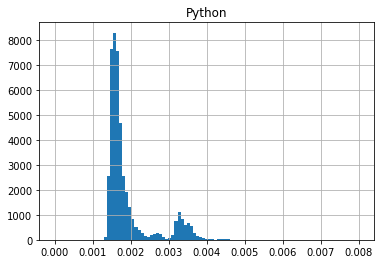

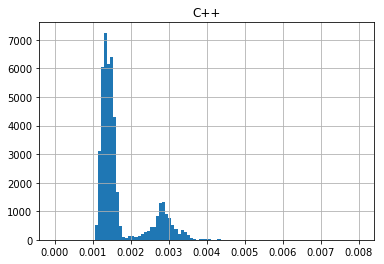

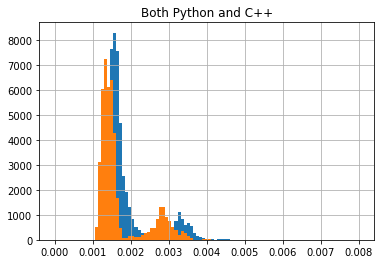

In [37]:
# Figure 1 - Time histograms
bins = np.linspace(0.0,0.008,100)
plt.figure(1)
dt_py.hist(bins=bins)
plt.title('Python')
plt.figure(2)
dt_cc.hist(bins=bins)
plt.title('C++')
plt.figure(3)
dt_py.hist(bins=bins)
dt_cc.hist(bins=bins)
plt.title('Both Python and C++')

We can see that the C++ implementation is slightly of lower latency and both implementations generally stay below 5 ms per step. 

Let's then compare the step execution time over the whole time span.

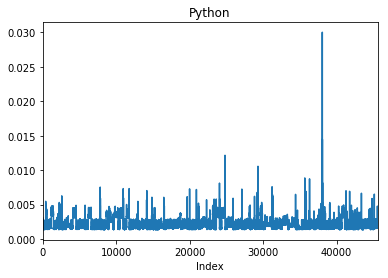

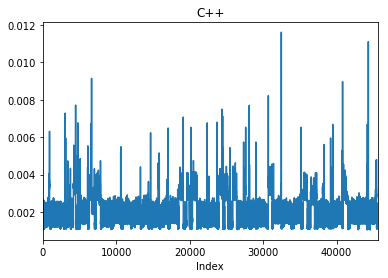

In [38]:
plt.figure(4)
dt_py.plot()
plt.title('Python')

plt.figure(5)
dt_cc.plot()
plt.title('C++')

If we look at the timing over all the steps we can see that there are fluctioations on both but there are few much higher peaks in the Python implementation.

## Steering Decisions

The timing results are only comparable if both inference implementations result in the same steering decisions.
To analyze this let's plot the outputs of the inference model as function of the images. We should expect the functions to look identical. 

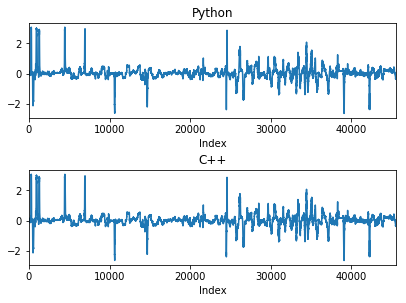

In [39]:
plt.figure(6)
plt.title('Steering action over time')
plt.subplot(211)
deg_py.plot()
plt.title('Python')
plt.subplot(212)
deg_cc.plot()
plt.title('C++')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.55,
                    wspace=0.35)

From the above graphs it is clear that both models work identically or at least essentially identically and perform the same decisions when provided the same data. This is what we would expect.

## Conclusions

We naturally cannot make wide ranging recommensations only based on ~40k images fed through a very basic TensorFlow based self driving car steering model but the results are in alignment with our initialy hypothesis. The C++ model has consistently slightly lower latency than the corresponding Python model. Furthermore and more importantly the worst performance of the C++ model is one third of the worst performance of the Python model. However we don't have enough statistics to evaluate the real-world implications. We would need to run through much more data to make any statistically significant conclusions. 

In this project we used standard Linux 4.8 kernel and a NVIDIA GTX 1060 GPU. To improve the timing determinism even further a hard real-time or soft real-time operating system could be used. Linux has a low latency kernel that provides soft real-time capabilities. This would allow reducing the maximum latency of high priority tasks at the expense of lower priority tasks. Furthermore there is also a Preempt RT kernel patch for Linux kernel that provides hard real-time guarantees. Hard real-time does not reduce latency over soft real-time. However it provides guarantees that the inference would be executed at a specific frequency and guaranteed specific CPU resources. But these guarantees are only valuable if everything in the critical time loop are implemented in a specific way. 

Based on these results C++ implementation has latency fluctuations of around 10 ms. This seems to be acceptable level of uncertainty for real-world self driving cars as long as inference is only used to make vehicle control decisions. However we don't have enough statistics to evaluate if the C++ model will actually stay below ~10 ms consistently or if we were just lucky. Hard real-time environment is definitely recommended for mission critical control systems like self driving cars. 